# Inizializzazione Rete Neurale e prima run in assenza di algoritmi evolutivi, usando parametri casuali

In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import datasets
from sklearn.neural_network import MLPClassifier
import multiprocessing

In [5]:
import warnings
from deap import tools, creator, base, algorithms
from sklearn.exceptions import ConvergenceWarning

# Filtra il ConvergenceWarning di scikit-learn
#warnings.filterwarnings("ignore", category=ConvergenceWarning)

Import del dataset relativo ai tumori al cervello

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/Fa4H/computational_intelligence/refs/heads/main/brain_tumor.csv")
df.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


Split del dataset in test set e train set

In [7]:
X, y = df.iloc[:, 2:].copy(), df.iloc[:, 1].copy()

X_tr_val, X_test, y_tr_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_tr_val, y_tr_val, test_size = 0.2, random_state = 1, stratify = y_tr_val)

vals, counts = np.unique(y_val, return_counts=True)
#print(vals)    # → valori unici
#print(counts)
nums_0 = counts[0]
nums_1 = counts[1]

Standardizzazione del set usando la StandardScaler

In [8]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)
print(X_train_std[:3])

[[-6.54013686e-001 -1.04600901e+000 -1.17227122e+000  1.93297649e+000
  -4.26414660e-001 -2.85840585e-001 -9.13919772e-001  1.63084672e+000
   1.96569002e+000  1.56152288e+000 -1.36966393e+000  4.27299064e-001
  -1.06817439e-168]
 [-5.84399071e-001 -1.23457922e+000 -1.55066360e+000  5.44237107e-001
  -7.00857964e-001 -3.61422029e-001 -1.17019695e+000  7.01991423e-001
   4.96076105e-001  1.28815196e+000 -1.63514246e+000  4.60176688e-001
  -1.06817439e-168]
 [-3.11681472e-001 -6.30003861e-001 -5.44972990e-001  1.19426490e-001
  -3.97706152e-001 -2.80156301e-001 -2.05106702e-001  3.63985289e-001
   8.39920927e-002  1.32471230e-001  5.05204733e-002 -3.68980443e-001
  -1.06817439e-168]]


Inizializzazione della rente neurale usando MLPClassifier

In [9]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1000, activation="logistic", alpha=0.1, solver="sgd", learning_rate="constant", learning_rate_init=0.001, random_state=1, shuffle=True, tol=0.0001, verbose=True, warm_start=False)

mlp.fit(X_train_std, y_train)

Iteration 1, loss = 0.76287004
Iteration 2, loss = 0.74967992
Iteration 3, loss = 0.73541140
Iteration 4, loss = 0.72346319
Iteration 5, loss = 0.71421951
Iteration 6, loss = 0.70668276
Iteration 7, loss = 0.70112046
Iteration 8, loss = 0.69703563
Iteration 9, loss = 0.69357325
Iteration 10, loss = 0.69117901
Iteration 11, loss = 0.68948658
Iteration 12, loss = 0.68804510
Iteration 13, loss = 0.68693518
Iteration 14, loss = 0.68623891
Iteration 15, loss = 0.68560838
Iteration 16, loss = 0.68515927
Iteration 17, loss = 0.68457907
Iteration 18, loss = 0.68421932
Iteration 19, loss = 0.68385667
Iteration 20, loss = 0.68359858
Iteration 21, loss = 0.68333579
Iteration 22, loss = 0.68310690
Iteration 23, loss = 0.68292302
Iteration 24, loss = 0.68272293
Iteration 25, loss = 0.68244832
Iteration 26, loss = 0.68228010
Iteration 27, loss = 0.68204781
Iteration 28, loss = 0.68189943
Iteration 29, loss = 0.68174647
Iteration 30, loss = 0.68164566
Iteration 31, loss = 0.68142430
Iteration 32, los

MLPClassifier(activation='logistic', alpha=0.1, hidden_layer_sizes=(10, 10),
              max_iter=1000, random_state=1, solver='sgd', verbose=True)

Report di classificazione più confusion matrix

In [10]:
pred_val = mlp.predict(X_val_std)
c = confusion_matrix(pred_val, y_val)
print(classification_report(pred_val, y_val, zero_division=0))
print(c)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       341
           1       0.96      0.98      0.97       261

    accuracy                           0.97       602
   macro avg       0.97      0.97      0.97       602
weighted avg       0.97      0.97      0.97       602

[[329  12]
 [  4 257]]


# Definizione algoritmo evolutivo genetico che andrà a lavorare sulle reti neurali

Lavorando su codifica intera, andiamo a codificare tutti gli iperparametri di cui faremo il tuning

In [11]:
def hidden_layers_encoding(min_num_layers = 1, max_num_layers = 3, min_neurons = 1, max_neurons = 10):
  numlays = random.randint(min_num_layers, max_num_layers)
  # Genera un numero casuale di neuroni per ogni layer, tra min_neurons e max_neurons
  # Restituisce una lista di neuroni per ogni layer
  a = [random.randint(min_neurons, max_neurons) for i in range(numlays)]
  return a

def max_iter_encoding(min_maxiter = 300, max_maxiter = 5000):
  return random.randint(min_maxiter, max_maxiter)

def activation_encoding(min_activation = 0, max_activation = 3):
  return random.randint(min_activation, max_activation)

def alpha_encoding(min_alpha = 10**-9, max_alpha = 10**0, exp_step = 0.1):
    """
    encoding: alpha appartenente a range di Reali (phenotype space) --->  numero di step appartenente a sottoinsieme di Interi (genotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di encoding genera un numero naturale tra 0 ed un numero intero massimo che è determinato
    dal numero totale ammissibile di valori distinti discretizzati di alpha, tenendo in conto
    la restrizione data dal range [min_alpha, max_alpha] e exp_step.
    Considerando la discretizzazione lineare nella potenza di 10, questo intero corrisponde semanticamente al numero di exp_step da aggiungere
    a min_exp per ottenere l'esponente da dare a 10 per ottenere alpha.

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_alpha)
    max_exp = np.log10(max_alpha)
    num_step = int((max_exp - min_exp) / exp_step)
    # Estraggo il valore del gene: un valore intero randomico di step da fare
    gene_value = random.randint(0, num_step)

    return gene_value

def learning_rate_init_encoding(min_lri = 10**-9,  max_lri = 10**0,  exp_step = 0.1):
    """
    encoding: lri appartenente a range di Reali (phenotype space) --->  numero di step appartenente a sottoinsieme di Interi (genotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di encoding genera un numero naturale tra 0 ed un numero intero massimo che è determinato
    dal numero totale ammissibile di valori distinti discretizzati di learning_rate_init, tenendo in conto
    la restrizione data dal range [min_lri, max_lri] e exp_step.
    Considerando la discretizzazione lineare nella potenza di 10, questo intero corrisponde semanticamente al numero di exp_step da aggiungere
    a min_exp per ottenere l'esponente da dare a 10 per ottenere learning_rate_init.

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_lri)
    max_exp = np.log10(max_lri)
    num_step = int((max_exp - min_exp) / exp_step)
    # Estraggo il valore del gene: un valore intero randomico di step da fare
    gene_value = random.randint(0, num_step)

    return gene_value

def tol_encoding(min_tol = 10**-9,  max_tol = 10**0,  exp_step = 0.1):
    """
    encoding: tol appartenente a range di Reali (phenotype space) --->  numero di step appartenente a sottoinsieme di Interi (genotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di encoding genera un numero naturale tra 0 ed un numero intero massimo che è determinato
    dal numero totale ammissibile di valori distinti discretizzati di tol, tenendo in conto
    la restrizione data dal range [min_tol, max_tol] e exp_step.
    Considerando la discretizzazione lineare nella potenza di 10, questo intero corrisponde semanticamente al numero di exp_step da aggiungere
    a min_exp per ottenere l'esponente da dare a 10 per ottenere tol.

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_tol)
    max_exp = np.log10(max_tol)
    num_step = int((max_exp - min_exp) / exp_step)
    # Estraggo il valore del gene: un valore intero randomico di step da fare
    gene_value = random.randint(0, num_step)

    return gene_value
encoding = [hidden_layers_encoding, max_iter_encoding, activation_encoding, alpha_encoding, learning_rate_init_encoding, tol_encoding]


Definiamo ove fatto la codifica, le funzioni di decodifica, per andare a visualizzare gli output reali

In [12]:
def activation_decoding(gene_value):
    if not hasattr(activation_decoding, "_phenotypes"):
        activation_decoding._phenotypes = ["relu", "tanh", "logistic", "identity"]  # solo alla prima chiamata
    return activation_decoding._phenotypes[gene_value] # riusa il dizionario nelle chiamate successive

def alpha_decoding(gene_value, min_alpha = 10**-9, max_alpha = 10**0, exp_step = 0.1):
    """
    decoding: numero di step appartenente a sottoinsieme di Interi (genotype space) ---> alpha appartenente a range di Reali (phenotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di decoding assume il valore intero del gene (gene_value) e lo associa semanticamente al numero
    di exp_step che bisogna aggiungere al min_exp per ottenere l'esponente da dare a 10 per ottenere il corrispondente alpha.
    alpha = 10**(min_exp + gene_value*exp_step) -- lineare nell'esponente --

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_alpha)
    max_exp = np.log10(max_alpha)
    num_step = int((max_exp - min_exp) / exp_step)
    # Calcolo l'esponente da dare a 10 partendo dal valore minimo e aggiungendo ad esso un numero "gene_value" di exp_step (è lineare nell'esponente)
    esp = min_exp + gene_value*exp_step
    # Calcolo alpha
    alpha = 10**esp

    return alpha

def learning_rate_init_decoding(gene_value, min_lri = 10**-9,  max_lri = 10**0,  exp_step = 0.1):
    """
    decoding: numero di step appartenente a sottoinsieme di Interi (genotype space) ---> lri appartenente a range di Reali (phenotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di decoding assume il valore intero del gene (gene_value) e lo associa semanticamente al numero
    di exp_step che bisogna aggiungere al min_exp per ottenere l'esponente da dare a 10 per ottenere il corrispondente learning_rate_init.
    lri = 10**(min_exp + gene_value*exp_step) -- lineare nell'esponente --

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_lri)
    max_exp = np.log10(max_lri)
    num_step = int((max_exp - min_exp) / exp_step)
    # Calcolo l'esponente da dare a 10 partendo dal valore minimo e aggiungendo ad esso un numero "gene_value" di exp_step (è lineare nell'esponente)
    esp = min_exp + gene_value*exp_step
    # Calcolo lri
    lri = 10**esp

    return lri

def tol_decoding(gene_value, min_tol = 10**-9,  max_tol = 10**0,  exp_step = 0.1):
    """
    decoding: numero di step appartenente a sottoinsieme di Interi (genotype space) ---> tol appartenente a range di Reali (phenotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di decoding assume il valore intero del gene (gene_value) e lo associa semanticamente al numero
    di exp_step che bisogna aggiungere al min_exp per ottenere l'esponente da dare a 10 per ottenere il corrispondente tol.
    tol = 10**(min_exp + gene_value*exp_step) -- lineare nell'esponente --

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_tol)
    max_exp = np.log10(max_tol)
    num_step = int((max_exp - min_exp) / exp_step)
    # Calcolo l'esponente da dare a 10 partendo dal valore minimo e aggiungendo ad esso un numero "gene_value" di exp_step (è lineare nell'esponente)
    esp = min_exp + gene_value*exp_step
    # Calcolo lri
    tol = 10**esp

    return tol

Funzione che prende in input i massimi e i minimi dei vari iperparametri e va a calcolare i bound, in una lista

In [13]:

def bound_setup(min_neurons = 1, max_neurons = 10, min_maxiter = 300, max_maxiter = 5000, min_activation = 0, max_activation = 3,
                min_alpha = 10**-9, max_alpha = 10**0, exp_step_alpha = 0.1, min_lri = 10**-9,  max_lri = 10**0,  exp_step_lri = 0.1,
                  min_tol = 10**-9,  max_tol = 10**0, exp_step_tol = 0.1):          
    """
    Questa funzione restituisce i bound per ogni gene, in modo che il toolbox di DEAP possa essere configurato correttamente.
    """
    min_exp_alpha = np.log10(min_alpha)
    max_exp_alpha = np.log10(max_alpha)
    num_step_alpha = int((max_exp_alpha - min_exp_alpha) / exp_step_alpha)
    min_exp_lri = np.log10(min_lri)
    max_exp_lri = np.log10(max_lri)
    num_step_lri = int((max_exp_lri - min_exp_lri) / exp_step_lri)
    min_exp_tol = np.log10(min_tol)
    max_exp_tol = np.log10(max_tol)
    num_step_tol = int((max_exp_tol - min_exp_tol) / exp_step_tol)
    bound_min = [min_neurons, min_maxiter, min_activation, 0, 0, 0]
    bound_max = [max_neurons, max_maxiter, max_activation, num_step_alpha, num_step_lri, num_step_tol]
    return  bound_min, bound_max

bound_min, bound_max = bound_setup()

Definiamo le funzioni per la selezione delle nuove generazioni, che andremo ad inserire nel genetico come iperparametro

In [14]:
def age_based(offspring, pop):
    return offspring
def fitness_based(offspring, pop):
    return tools.selBest(offspring + pop, k=len(pop))

def new_pop_decoding(gene_value):
    if not hasattr(new_pop_decoding, "_phenotypes"):
        new_pop_decoding._phenotypes = (age_based, fitness_based)  # solo alla prima chiamata
    return new_pop_decoding._phenotypes[gene_value] # riusa il dizionario nelle chiamate successive

In [15]:
def MLPC_decoding(individual):
    """
    Decodifica un individuo in un dizionario che rappresenta i parametri della rete neurale.
    """

    hidden_layers = individual[0]
    max_iter = individual[1]
    activation = activation_decoding(individual[2])
    alpha = alpha_decoding(individual[3])
    learning_rate_init = learning_rate_init_decoding(individual[4])
    tol = tol_decoding(individual[5])
    
    return {
        "hidden_layers": hidden_layers,
        "max_iter": max_iter,
        "activation": activation,
        "alpha": alpha,
        "learning_rate_init": learning_rate_init,
        "tol": tol
    }

## Definiamo il problema e la funzione di valutazione che genererà le reti neurali

In [16]:
def setup_problem():
    creator.create("FitnessMax", base.Fitness, weights = (1.0,))
    creator.create("Individual", list, fitness = creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initCycle, creator.Individual, encoding, n = 1)

    toolbox.register("evaluate", evalFitness)

    return toolbox
def evalFitness(individual):
        # decoding (inverse representation to create the corresponding phenotype)
        params = MLPC_decoding(individual)
        # costruzione e apprendimento della NN
        mlp = MLPClassifier(hidden_layer_sizes=params["hidden_layers"], activation=params["activation"], alpha=params["alpha"], 
                            max_iter=params["max_iter"], learning_rate_init=params["learning_rate_init"], tol=params["tol"], early_stopping=True)
        mlp.fit(X_train_std, y_train)
        # validazione
        pred_val = mlp.predict(X_val_std)
        # quality measure in the phenotype space
        report = classification_report(pred_val, y_val, zero_division=0,output_dict=True)
        f1_class0 = report['0']['f1-score']
        f1_class1 = report['1']['f1-score']
        f1_weighted = (f1_class0*nums_0 + f1_class1*nums_1)/(nums_0 + nums_1)

        # aggiunta prova per grafico 3d
        media_precision = (report['0']['precision']*nums_0 + report['1']['precision'])*nums_1 / (nums_0 + nums_1)
        media_recall = (report['0']['recall']*nums_0 + report['1']['recall'])*nums_1 / (nums_0 + nums_1)
        f1_nostrano = (2 * media_precision * media_recall) / (media_precision + media_recall)
        return f1_weighted, media_precision, media_recall, f1_nostrano

toolbox_problema = setup_problem()


Definiamo l'effettivo algoritmo genetico

In [17]:
def GAint(toolbox , popSize, CXPB, MUTPB, indpbMUT , maxEvals, 
       cxFUNC, indpbCX,  mutFUNC, selFUNC, 
       tournsize, new_pop, verbose = False, maxGens = None):

    
    # Registriamo altri oggetti caratteristici dell'algoritmo e non del problema
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    if selFUNC == tools.selTournament:
        toolbox.register("parent_select", tools.selTournament, tournsize=tournsize)
    else:
        toolbox.register("parent_select", selFUNC)
    if cxFUNC == tools.cxUniform:
        toolbox.register("mate", cxFUNC, indpb=indpbCX)
    else:
        toolbox.register("mate", cxFUNC)
    toolbox.register("mutate", mutFUNC, indpb=indpbMUT)
    toolbox.register("next_gen", new_pop)
    # definizione statistiche
    stats = tools.Statistics(key = lambda ind: ind.fitness.values)
    def Mean(L):
        return round(np.mean(L), 10)
    def Std(L):
        return round(np.std(L), 10)
    def Min(L):
        return round(np.min(L), 10)
    def Max(L):
        return round(np.max(L), 10)

    stats.register("avg", Mean)
    stats.register("std", Std)
    stats.register("min", Min)
    stats.register("max", Max)

    halloffame = tools.HallOfFame(1)

    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + stats.fields

    # creazione della popolazione
    pop = toolbox.population(popSize)

    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitness = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness):
        ind.fitness.values = fit[0], 
        precision = fit[1]
        recall = fit[2]
        f1_nostrano = fit[3] 


    halloffame.update(pop)
    rec = stats.compile(pop)
    logbook.record(gen = 0, nevals = len(invalid_ind) , **rec)
    if verbose:
        print(logbook.stream)
    g = 0
    while np.sum(logbook.select("nevals")) < maxEvals:
        g += 1
        # Select the next generation of parents. These are only links to the individuals of pop. Then, need to deep clone them to avoid changes in place
        sel_offspring = toolbox.parent_select(pop, len(pop)) # selects n(=len(pop)) individuals from n with duplicates allowed
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, sel_offspring))
        # Apply crossover on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]): # Parents early selected will be the childrens because toolbox.mate changes them in place
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        # Apply mutation on the offspring
        for mutant in offspring:
            if random.random() < MUTPB:
                if mutFUNC == mutRandomDecay:
                    toolbox.mutate(mutant, current_evals = np.sum(logbook.select("nevals")), maxEvals=maxEvals)
                else:
                    toolbox.mutate(mutant)
                del mutant.fitness.values
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the halloffame with the generated individuals
        halloffame.update(offspring)
        # The population is entirely replaced by the offspring (age-based selection) or chosen from best fitness individuals
        pop[:] = toolbox.next_gen(offspring, pop)
        # Append the current generation statistics to the logbook
        rec = stats.compile(pop)
        logbook.record(gen = g, nevals = len(invalid_ind), **rec)
        if verbose:
            print(logbook.stream)
    # Decoding the population and the best individual
    decoded_pop = [MLPC_decoding(ind) for ind in pop]
    decoded_best = MLPC_decoding(halloffame[0])
    return decoded_pop, logbook, decoded_best,  halloffame[0].fitness.values[0]

il GA ha i seguenti geni:
- popSize: range [5, 20]
- CXPB: [0.1, 0.9]
- MUTPB: [0.05, 0.5]
- indpbMUT: [0.05, 0.5]
- maxEvals: [popSize, 10*popSize]
- cxFUNC: [cxOnePoint, cxTwoPoint, cxUniform] se si usa cxUniform serve l'attributo indpbCX
- indpbCX: [0.2, 0.8] 
- mutFUNC: [mutReinit, mutGaussianRound, mutDecay]
- selFunc: [selTournament, selRoulette, selRandom, selBest] se si usa selTournament serve l'attributo tournsize
- tournsize: tourn = [int(0.3*popSize), int(0.5*popSize)]   con restrizione toursize = max(3, tourn)   
- new_pop: [age_based, fitness_based]

## Iniziamo a definire l'algoritmo genetico che farà il tuning degli iperparametri del genetico precedente

Definizione delle funzioni di encoding e decoding per passare da codifica reale a intera e viceversa

In [18]:
# FUNZIONI DI ENCODING E DECODING

def popSize_encoding():
    popsize = random.randint(10, 20)
    return popsize

def CXPB_encoding(min_CXPB = 0.2, max_CXPB = 0.8, step = 0.1):
    num_step = int((max_CXPB - min_CXPB) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def CXPB_decoding(gene_value, min_CXPB = 0.2, max_CXPB = 0.8, step = 0.1):
    cxpb = min_CXPB + gene_value*step
    return cxpb

def MUTPB_encoding(min_MUTPB = 0.2, max_MUTPB = 0.8, step = 0.1):
    num_step = int((max_MUTPB - min_MUTPB) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def MUTPB_decoding(gene_value, min_MUTPB = 0.2, max_MUTPB = 0.8, step = 0.1):
    mutpb = min_MUTPB + gene_value*step
    return mutpb

def indpbMUT_encoding(min_indpbMUT = 0.1, max_indpbMUT = 0.8, step = 0.1):
    num_step = int((max_indpbMUT - min_indpbMUT) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def indpbMUT_decoding(gene_value, min_indpbMUT = 0.1, max_indpbMUT = 0.8, step = 0.1):
    indpbMUT = min_indpbMUT + gene_value*step
    return indpbMUT
popSize = popSize_encoding()

def maxEvals_encoding(min_maxEvals = 40, max_maxEvals = 200): 
    maxEvals = random.randint(min_maxEvals, max_maxEvals)
    return maxEvals

def cxFUNC_encoding():
  return random.randint(0, 2)

def cxFUNC_decoding(gene_value):
    if not hasattr(cxFUNC_decoding, "_phenotypes"):
        cxFUNC_decoding._phenotypes = (tools.cxOnePoint, tools.cxTwoPoint, tools.cxUniform)
    return cxFUNC_decoding._phenotypes[gene_value]

def indpbCX_encoding(min_indpbCX = 0.2, max_indpbCX = 0.8, step = 0.1):
    num_step = int((max_indpbCX - min_indpbCX) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def indpbCX_decoding(gene_value, min_indpbCX = 0.2, max_indpbCX = 0.8, step = 0.1):
    indpbCX = min_indpbCX + gene_value*step
    return indpbCX

def mutFUNC_encoding():
    return random.randint(0, 2)

def mutFUNC_decoding(gene_value):
    if not hasattr(mutFUNC_decoding, "_phenotypes"):
        mutFUNC_decoding._phenotypes = (mutReinit, mutGaussianRound, mutRandomDecay)
    return mutFUNC_decoding._phenotypes[gene_value]  

def selFUNC_encoding():
    return random.randint(0, 3)

def selFUNC_decoding(gene_value):
    if not hasattr(selFUNC_decoding, "_phenotypes"):
        selFUNC_decoding._phenotypes = (tools.selTournament, tools.selRoulette, tools.selRandom, tools.selBest)
    return selFUNC_decoding._phenotypes[gene_value]

def tournsize_encoding(min_tournsize = 2, max_tournsize = 4):
    tournsize =  random.randint(min_tournsize, max_tournsize)
    return tournsize

def age_based(offspring, pop):
    return offspring
def fitness_based(offspring, pop):
    return tools.selBest(offspring + pop, k=len(pop))

def new_pop_encoding():
    return random.randint(0, 1)

def new_pop_decoding(gene_value):
    if not hasattr(new_pop_decoding, "_phenotypes"):
        new_pop_decoding._phenotypes = (age_based, fitness_based)  
    return new_pop_decoding._phenotypes[gene_value] 

encoding_GA = [popSize_encoding, CXPB_encoding, MUTPB_encoding, indpbMUT_encoding, maxEvals_encoding, 
               cxFUNC_encoding, indpbCX_encoding, mutFUNC_encoding, selFUNC_encoding, tournsize_encoding, new_pop_encoding]


Definiamo qui le 3 funzioni di mutazione che andremo ad utilizzare nel genetico

In [19]:
def mutReinit(individual, indpb):
    for i in range(len(encoding)):
        if random.random() < indpb:
            individual[i] = encoding[i]()
    return individual

def mutGaussianRound(individual, indpb, boundmax = bound_max, boundmin = bound_min):
    if random.random() < indpb:
        # Applica mutazione gaussiana al primo gene (numero di neuroni per strato)
        for i in range(len(individual[0])):
            mutated_value = individual[0][i] + random.gauss(0, (boundmax[0]-boundmin[0])*10/100)
            # Arrotonda al numero intero più vicino
            mutated_value = int(round(mutated_value))
            # Clampa il valore entro i limiti validi
            mutated_value = int(max(boundmin[0], min(mutated_value, boundmax[0])))
            individual[0][i] = mutated_value
    for i in range(1, len(individual)):
        if random.random() < indpb:
            # Applica rumore gaussiano
            mutated_value = individual[i] + random.gauss(0, (boundmax[i]-boundmin[i])*10/100)
            # Arrotonda al numero intero più vicino
            mutated_value = int(round(mutated_value))
            # Clampa il valore entro i limiti validi per quel gene
            mutated_value = int(max(boundmin[i], min(mutated_value, boundmax[i])))
            individual[i] = mutated_value
    return individual

def mutRandomDecay(individual, current_evals, maxEvals, indpb, boundmin = bound_min, boundmax = bound_max):
    """
        Mutazione che decresce nel tempo.
    """
    # Calcola il fattore di decrescita basato sul numero di valutazioni correnti
    decay_factor = 1 - current_evals / maxEvals

    if random.random() < indpb:
        # Applica mutazione gaussiana al primo gene (numero di neuroni per strato)
        for i in range(len(individual[0])):
            # Applica la mutazione decrescente
            mut = random.randint(-1, 1)*individual[0][i]*decay_factor + individual[0][i]
            # Clampa il valore entro i limiti validi per quel gene
            individual[0][i] = int(max(boundmin[0], min(mut, boundmax[0])))
    for i in range(1, len(individual)):
        if random.random() < indpb:
            # Applica la mutazione decrescente
            mut = random.randint(-1, 1)*individual[i]*decay_factor + individual[i]
            # Clampa il valore entro i limiti validi per quel gene
            individual[i] = int(max(boundmin[i], min(mut, boundmax[i])))
    return individual

Questa è la funzione di mutazione che useremo nel GA che lavorerà con gli altri GA

In [20]:
def mutReinitGA(individual, indpb):
    for i in range(min(len(individual), len(encoding_GA))):
        if random.random() < indpb:
            individual[i] = encoding_GA[i]()
    return individual

In [21]:
def GA_decoding(individual):
    popsize = individual[0]
    cxpb = CXPB_decoding(individual[1])
    mutpb = MUTPB_decoding(individual[2])
    indpbmut = indpbMUT_decoding(individual[3])
    maxevals = individual[4]
    cxfunc = cxFUNC_decoding(individual[5])
    indpbcx = indpbCX_decoding(individual[6])
    mutfunc = mutFUNC_decoding(individual[7])
    selfunc = selFUNC_decoding(individual[8])
    tsize = individual[9]
    newpop = new_pop_decoding(individual[10])
    return {
        "popSize": popsize,
        "CXPB": cxpb,
        "MUTPB": mutpb,
        "indpbMUT": indpbmut,
        "maxEvals": maxevals,
        "cxFUNC": cxfunc,
        "indpbCX": indpbcx,
        "mutFUNC": mutfunc,
        "selFUNC": selfunc,
        "tournsize": tsize,
        "new_pop": newpop
    }

Definiamo il problema e la funzione di valutazione per il GA più esterno, ovvero quello che lavorerà sugli altri GA

In [22]:
def setup_problem_GA():
    creator.create("FitnessMaxGA", base.Fitness, weights = (1.0,))
    creator.create("IndividualGA", list, fitness = creator.FitnessMaxGA)

    toolbox = base.Toolbox()
    toolbox.register("individualGA", tools.initCycle, creator.IndividualGA, encoding_GA, n = 1)

    toolbox.register("evaluateGA", evalFitnessGA)

    return toolbox
def evalFitnessGA(individual):
        # decoding (inverse representation to create the corresponding phenotype)
        params = GA_decoding(individual)
        
        runs = 3
        runs_best_fitness = []
        for run in range(runs):           
            pop, logbook, hof, hoffit = GAint(toolbox = toolbox_problema, popSize = params["popSize"], CXPB = params["CXPB"], 
                                              MUTPB = params["MUTPB"], indpbMUT = params["indpbMUT"], maxEvals = params["maxEvals"], cxFUNC = params["cxFUNC"], 
                                              indpbCX = params["indpbCX"], mutFUNC = params["mutFUNC"], selFUNC = params["selFUNC"], 
                                              tournsize = params["tournsize"], new_pop = params["new_pop"])
            runs_best_fitness.append(logbook.select("avg")[-1])
        print(runs_best_fitness)
        return np.mean(runs_best_fitness), 
toolbox_GA = setup_problem_GA()

Definiamo l'effettivo GA esterno

In [160]:
def GAext(toolbox = toolbox_GA , popSize = 5, CXPB = 0.7, MUTPB = 0.2, indpbMUT = 0.2 , maxEvals = 25, 
       cxFUNC = tools.cxOnePoint, indpbCX = 0.1,  mutFUNC = mutReinitGA, selFUNC = tools.selRoulette, 
       tournsize = 3, new_pop = age_based, verbose = False, maxGens = None):
    
    pool = multiprocessing.Pool()  # Usa tutti i core disponibili
    toolbox.register("map", pool.map)

    # Registriamo altri oggetti caratteristici dell'algoritmo e non del problema
    toolbox.register("populationGA", tools.initRepeat, list, toolbox.individualGA)
    if selFUNC == tools.selTournament:
        toolbox.register("parent_selectGA", tools.selTournament, tournsize=tournsize)
    else:
        toolbox.register("parent_selectGA", selFUNC)
    if cxFUNC == tools.cxUniform:
        toolbox.register("mateGA", cxFUNC, indpb=indpbCX)
    else:
        toolbox.register("mateGA", cxFUNC)
    toolbox.register("mutateGA", mutFUNC, indpb=indpbMUT)
    toolbox.register("next_genGA", new_pop)
    # definizione statistiche
    statsGA = tools.Statistics(key = lambda ind: ind.fitness.values)
    def Mean(L):
        return round(np.mean(L), 10)
    def Std(L):
        return round(np.std(L), 10)
    def Min(L):
        return round(np.min(L), 10)
    def Max(L):
        return round(np.max(L), 10)

    statsGA.register("avgGA", Mean)
    statsGA.register("stdGA", Std)
    statsGA.register("minGA", Min)
    statsGA.register("maxGA", Max)

    halloffameGA = tools.HallOfFame(1)

    logbookGA = tools.Logbook()
    logbookGA.header = ["gen", "nevals"] + statsGA.fields

    # creazione della popolazione
    popGA = toolbox.populationGA(popSize)

    invalid_ind = [ind for ind in popGA if not ind.fitness.valid]
    fitness = toolbox.map(toolbox.evaluateGA, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness):
        ind.fitness.values = fit


    halloffameGA.update(popGA)
    recGA = statsGA.compile(popGA)
    logbookGA.record(gen = 0, nevals = len(invalid_ind) , **recGA)
    if verbose:
        print(logbookGA.stream)
    g = 0
    """
    best_fitness_ever = -np.inf
    no_improve_count = 0
    early_stop_threshold = 3
    """
    while np.sum(logbookGA.select("nevals")) < maxEvals:
        g += 1
        # Select the next generation of parents. These are only links to the individuals of pop. Then, need to deep clone them to avoid changes in place
        sel_offspringGA = toolbox.parent_selectGA(popGA, len(popGA)) # selects n(=len(pop)) individuals from n with duplicates allowed
        # Clone the selected individuals
        offspringGA = list(map(toolbox.clone, sel_offspringGA))
        # Apply crossover on the offspring
        for child1, child2 in zip(offspringGA[::2], offspringGA[1::2]): # Parents early selected will be the childrens because toolbox.mate changes them in place
            if random.random() < CXPB:
                toolbox.mateGA(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        # Apply mutation on the offspring
        for mutant in offspringGA:
            if random.random() < MUTPB:
                toolbox.mutateGA(mutant)
                del mutant.fitness.values
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspringGA if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluateGA, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the halloffame with the generated individuals
        halloffameGA.update(offspringGA)
        # The population is entirely replaced by the offspring (age-based selection) or chosen from best fitness individuals
        popGA[:] = toolbox.next_genGA(offspringGA, popGA)
        # Append the current generation statistics to the logbook
        recGA = statsGA.compile(popGA)
        logbookGA.record(gen = g, nevals = len(invalid_ind), **recGA)
        if verbose:
            print(logbookGA.stream)
        """
        current_best = recGA["maxGA"]
        if current_best > best_fitness_ever:
            best_fitness_ever = current_best
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if no_improve_count >= early_stop_threshold:
            if verbose:
                print(f"Early stopping: no improvement in {early_stop_threshold} generations. Stopped at generation {g}")
            break
        """


    # Decoding the population and the best individual
    decoded_bestGA = GA_decoding(halloffameGA[0])
    decoded_popGA = [GA_decoding(ind) for ind in popGA]
    
    return decoded_popGA, logbookGA, decoded_bestGA,  halloffameGA[0].fitness.values[0], g

popsGA, logbGA, hofGA, hoffitGA, gens = GAext()

[np.float64(0.7445484167), np.float64(0.3781871213), np.float64(0.8429162858)]
[np.float64(0.9781136853), np.float64(0.9767348143), np.float64(0.9770360369)]
[np.float64(0.9791251197), np.float64(0.9786980985), np.float64(0.9770568928)]
[np.float64(0.9817173132), np.float64(0.9824712962), np.float64(0.9800541292)]
[np.float64(0.9789807624), np.float64(0.9784912025), np.float64(0.979072132)]
[np.float64(0.9776711439), np.float64(0.9779720966), np.float64(0.978295765)]
[np.float64(0.9800590964), np.float64(0.983354265), np.float64(0.9817021625)]
[np.float64(0.9800590964), np.float64(0.9800664452), np.float64(0.9817021625)]
[np.float64(0.9833887043), np.float64(0.9817173132), np.float64(0.9818624881)]
[np.float64(0.9817166437), np.float64(0.9800590964), np.float64(0.9775082495)]
[np.float64(0.9800590964), np.float64(0.9850354122), np.float64(0.9800590964)]
[np.float64(0.9817173132), np.float64(0.9817242588), np.float64(0.9817173132)]
[np.float64(0.9800590964), np.float64(0.9800590964), np

In [23]:
logbGA.select("gen")

NameError: name 'logbGA' is not defined

Visualizziamo un grafico best vs generations per vedere il miglioramento del best

In [24]:
# Estrai le generazioni e i best fitness
generations = logbGA.select("gen")
best_fitnesses = np.array(logbGA.select("maxGA"))-np.array(logbGA.select("minGA"))

# Crea il grafico
plt.figure(figsize=(10, 5))
plt.plot(generations, best_fitnesses, marker='o', color='blue', label='Best fitness')
plt.title("Best Fitness per Generazione")
plt.xlabel("Generazione")
plt.ylabel("Fitness")
plt.grid(True)
#plt.ylim(0.9, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'logbGA' is not defined

# Implementazione Differential Evolution

In [25]:
def setup_problem():
    creator.create("FitnessMax", base.Fitness, weights = (1.0,))
    creator.create("Individual", list, fitness = creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initCycle, creator.Individual, encoding, n = 1)
    toolbox.register("evaluate", evalFitness)

    return toolbox
def evalFitness(individual):
        # decoding (inverse representation to create the corresponding phenotype)
        params = MLPC_decoding(individual)
        # costruzione e apprendimento della NN
        mlp = MLPClassifier(hidden_layer_sizes=params["hidden_layers"], activation=params["activation"], alpha=params["alpha"], 
                            max_iter=params["max_iter"], learning_rate_init=params["learning_rate_init"], tol=params["tol"], early_stopping=True)
        mlp.fit(X_train_std, y_train)
        # validazione
        pred_val = mlp.predict(X_val_std)
        # quality measure in the phenotype space
        report = classification_report(pred_val, y_val, zero_division=0,output_dict=True)
        f1_class0 = report['0']['f1-score']
        f1_class1 = report['1']['f1-score']
        f1_weighted = (f1_class0*nums_0 + f1_class1*nums_1)/(nums_0 + nums_1)

        # aggiunta prova per grafico 3d
        media_precision = (report['0']['precision']*nums_0 + report['1']['precision'])*nums_1 / (nums_0 + nums_1)
        media_recall = (report['0']['recall']*nums_0 + report['1']['recall'])*nums_1 / (nums_0 + nums_1)
        f1_nostrano = (2 * media_precision * media_recall) / (media_precision + media_recall)
        return f1_weighted, media_precision, media_recall, f1_nostrano

toolbox_problema = setup_problem()

/usr/local/python/3.12.1/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/python/3.12.1/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [26]:
def differential_mut(gena, genb, genc, pos, F, bound_max = bound_max, bound_min = bound_min):   
    
    if type(gena) is list:    
        # 1. Scegli casualmente la lista di riferimento
        r = random.randint(1, 3)  
        ref = {1: gena, 2: genb, 3: genc}[r]
        ref_len = min(len(gena), len(genb), len(genc))  # lunghezza minima tra le tre liste

        # 2. Troncamento o padding
        a_short = gena[:ref_len]
        b_short = genb[:ref_len]
        c_short = genc[:ref_len]

        # 3. Applichi la tua formula (es. differenza differenziale per DE)
        mutated_gene_float = list(np.array(a_short) + F*(np.array(b_short) - np.array(c_short)))
        mutated_gene = list(map(round, mutated_gene_float))
        if len(mutated_gene) != len(ref):
            # Se la lunghezza di mutated_gene non corrisponde a quella di ref, aggiungi len(ref) - len(mutated_gene) elementi da ref
            num_elements_to_add = len(ref) - len(mutated_gene)
            mutated_gene[ref_len:] = ref[-num_elements_to_add:]  # Assicurati che la lunghezza sia corretta
        for i in range(len(a_short)):
            if mutated_gene[i] < bound_min[pos]:
                mutated_gene[i] = min(gena[i], genb[i], genc[i])
            if mutated_gene[i] > bound_max[pos]:
                mutated_gene[i] = max(gena[i], genb[i], genc[i])
        
    else: # se il gene è un singolo valore intero
        mutated_gene = round(gena + F*(genb - genc))
        if mutated_gene < bound_min[pos]:
            mutated_gene = min(gena, genb, genc)
        if mutated_gene > bound_max[pos]:
            mutated_gene = max(gena, genb, genc)
    return mutated_gene

In [27]:
def DEint(toolbox, CR, F, popSize, maxEvals, maxGens = None, verbose = False):

    stats = tools.Statistics(key = lambda ind: ind.fitness.values)
    # Registriamo altri oggetti caratteristici dell'algoritmo e non del problema
    def Mean(L):
        return round(np.mean(L), 10)
    def Std(L):
        return round(np.std(L), 10)
    def Min(L):
        return round(np.min(L), 10)
    def Max(L):
        return round(np.max(L), 10)
        
    stats.register("avg", Mean)
    stats.register("std", Std)
    stats.register("min", Min)
    stats.register("max", Max)
    
    halloffame = tools.HallOfFame(1)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("select", tools.selRandom, k = 3)

    logbook = tools.Logbook()
    logbook.header = "gen", "nevals", "avg", "std", "min", "max"

    pop = toolbox.population(n = popSize)

    #Evaluate the individuals
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitness = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness):
        ind.fitness.values = fit[0],
        
    if halloffame is not None:
        halloffame.update(pop)
    rec = stats.compile(pop) if stats else {}
    logbook.record(gen = 0, nevals = len(invalid_ind) , **rec)
    if verbose:
        print(logbook.stream)
    g = 0   

    while np.sum(logbook.select("nevals")) < maxEvals:
        g += 1
        for k, agent in enumerate(pop):
            a, b, c = toolbox.select(pop)
            y = toolbox.clone(agent)
            index = random.randrange(len(agent))
            # Mutazione differenziale
            for i, value in enumerate(agent):
                if i == index or random.random() < CR:
                    y[i] = differential_mut(a[i], b[i], c[i], pos = i, F = F, bound_max = bound_max, bound_min = bound_min)
            eva = toolbox.evaluate(y)
            y.fitness.values = eva[0],
            if y.fitness.values[0] > agent.fitness.values[0]:
                pop[k] = y
        halloffame.update(pop)
        rec = stats.compile(pop)
        logbook.record(gen = g, nevals = len(pop), **rec)
        if verbose:
            print(logbook.stream)

    # Decoding the population and the best individual
    decoded_pop = [MLPC_decoding(ind) for ind in pop]
    decoded_best = MLPC_decoding(halloffame[0])
    return decoded_pop, logbook, decoded_best,  halloffame[0].fitness.values[0] 


#pop, logbook, hof, hof_fitness =  DEint(toolbox = toolbox_problema, CR = 0.25, F = 1, popSize = 30, maxEvals = 300) 

Il DE ha i seguenti geni:
- F [0, 1]
- CR [0, 1]
- popSize [5, 20]
- maxEvals [dipende da popSize]

In [28]:
def F_encoding(min_F = 10**-1, max_F = 10**0, exp_step = 0.1):
    """
    encoding: F appartenente a range di Reali (phenotype space) --->  numero di step appartenente a sottoinsieme di Interi (genotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di encoding genera un numero naturale tra 0 ed un numero intero massimo che è determinato
    dal numero totale ammissibile di valori distinti discretizzati di F, tenendo in conto
    la restrizione data dal range [min_F, max_F] e exp_step.
    Considerando la discretizzazione lineare nella potenza di 10, questo intero corrisponde semanticamente al numero di exp_step da aggiungere
    a min_exp per ottenere l'esponente da dare a 10 per ottenere F.

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_F)
    max_exp = np.log10(max_F)
    num_step = int((max_exp - min_exp) / exp_step)
    # Estraggo il valore del gene: un valore intero randomico di step da fare
    gene_value = random.randint(0, num_step)

    return gene_value


def CR_encoding(min_CR = 0.1, max_CR = 0.9, step = 0.1):
    num_step = int((max_CR - min_CR) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def popSize_DE_encoding(min_popSize = 10, max_popSize = 50):
    popsize = random.randint(min_popSize, max_popSize)
    return popsize

def maxEvals_DE_encoding(min_maxEvals = 50, max_maxEvals = 200): 
    maxEvals = random.randint(min_maxEvals, max_maxEvals)
    return maxEvals

DE_encoding = [popSize_DE_encoding, maxEvals_DE_encoding, F_encoding, CR_encoding]

In [29]:
def F_decoding(gene_value, min_F = 10**-1, max_F = 10**0, exp_step = 0.1):
    """
    decoding: numero di step appartenente a sottoinsieme di Interi (genotype space) ---> F appartenente a range di Reali (phenotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di decoding assume il valore intero del gene (gene_value) e lo associa semanticamente al numero
    di exp_step che bisogna aggiungere al min_exp per ottenere l'esponente da dare a 10 per ottenere il corrispondente F.
    F = 10**(min_exp + gene_value*exp_step) -- lineare nell'esponente --

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_F)
    max_exp = np.log10(max_F)
    num_step = int((max_exp - min_exp) / exp_step)
    # Calcolo l'esponente da dare a 10 partendo dal valore minimo e aggiungendo ad esso un numero "gene_value" di exp_step (è lineare nell'esponente)
    esp = min_exp + gene_value*exp_step
    # Calcolo F
    F = 10**esp

    return F

def CR_decoding(gene_value, min_CR = 0.1, max_CR = 0.9, step = 0.1):
    """
    Questa funzione decodifica il gene_value in un valore di CR per l'algoritmo DE.
    CR è il tasso di crossover che controlla la probabilità di combinare i geni.
    """
    CR = min_CR + gene_value*step
    return CR

In [30]:
def DE_decoding(individual):
    popsize = individual[0]
    maxevals = individual[1]
    f = F_decoding(individual[2])
    cr = CR_decoding(individual[3])
    return {
        "popSize": popsize,
        "maxEvals": maxevals,
        "F": f,
        "CR": cr
    }

In [31]:
def mutReinitDE(individual, indpb):
    """
    Mutazione che reinizializza i geni dell'individuo con nuovi valori casuali.
    """
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = DE_encoding[i]()
    return individual

In [32]:
def setup_problem_DE():
    creator.create("FitnessMaxDE", base.Fitness, weights = (1.0,))
    creator.create("IndividualDE", list, fitness = creator.FitnessMaxDE)

    toolbox = base.Toolbox()
    toolbox.register("individualDE", tools.initCycle, creator.IndividualDE, DE_encoding, n = 1)
    toolbox.register("evaluateDE", evalFitnessDE)

    return toolbox
def evalFitnessDE(individual):
        # decoding (inverse representation to create the corresponding phenotype)
        params = DE_decoding(individual)
        
        runs = 3
        runs_best_fitness = []
        for run in range(runs):           
            pop, logbook, hof, hoffit = DEint(toolbox = toolbox_problema, popSize = params["popSize"], maxEvals = params["maxEvals"], 
                                              F = params["F"], CR = params["CR"])            
            runs_best_fitness.append(logbook.select("avg")[-1])
        print(runs_best_fitness)
        return np.mean(runs_best_fitness), 
toolbox_DE = setup_problem_DE()

In [33]:
def GAextDE(toolbox = toolbox_DE , popSize = 5, CXPB = 0.7, MUTPB = 0.2, indpbMUT = 0.2 , maxEvals = 25, 
       cxFUNC = tools.cxOnePoint, indpbCX = 0.1,  mutFUNC = mutReinitDE, selFUNC = tools.selRoulette, 
       tournsize = 3, new_pop = age_based, verbose = False, maxGens = None):
    
    pool = multiprocessing.Pool()  # Usa tutti i core disponibili
    toolbox.register("map", pool.map)

    # Registriamo altri oggetti caratteristici dell'algoritmo e non del problema
    toolbox.register("populationDE", tools.initRepeat, list, toolbox.individualDE)
    if selFUNC == tools.selTournament:
        toolbox.register("parent_selectDE", tools.selTournament, tournsize=tournsize)
    else:
        toolbox.register("parent_selectDE", selFUNC)
    if cxFUNC == tools.cxUniform:
        toolbox.register("mateDE", cxFUNC, indpb=indpbCX)
    else:
        toolbox.register("mateDE", cxFUNC)
    toolbox.register("mutateDE", mutFUNC, indpb=indpbMUT)
    toolbox.register("next_genDE", new_pop)
    # definizione statistiche
    statsDE = tools.Statistics(key = lambda ind: ind.fitness.values)
    def Mean(L):
        return round(np.mean(L), 10)
    def Std(L):
        return round(np.std(L), 10)
    def Min(L):
        return round(np.min(L), 10)
    def Max(L):
        return round(np.max(L), 10)

    statsDE.register("avgDE", Mean)
    statsDE.register("stdDE", Std)
    statsDE.register("minDE", Min)
    statsDE.register("maxDE", Max)

    halloffameDE = tools.HallOfFame(1)

    logbookDE = tools.Logbook()
    logbookDE.header = ["gen", "nevals"] + statsDE.fields

    # creazione della popolazione
    popDE = toolbox.populationDE(popSize)

    invalid_ind = [ind for ind in popDE if not ind.fitness.valid]
    fitness = toolbox.map(toolbox.evaluateDE, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness):
        ind.fitness.values = fit


    halloffameDE.update(popDE)
    recDE = statsDE.compile(popDE)
    logbookDE.record(gen = 0, nevals = len(invalid_ind) , **recDE)
    if verbose:
        print(logbookDE.stream)
    g = 0
    """
    best_fitness_ever = -np.inf
    no_improve_count = 0
    early_stop_threshold = 3
    """
    while np.sum(logbookDE.select("nevals")) < maxEvals:
        g += 1
        # Select the next generation of parents. These are only links to the individuals of pop. Then, need to deep clone them to avoid changes in place
        sel_offspringDE = toolbox.parent_selectDE(popDE, len(popDE)) # selects n(=len(pop)) individuals from n with duplicates allowed
        # Clone the selected individuals
        offspringDE = list(map(toolbox.clone, sel_offspringDE))
        # Apply crossover on the offspring
        for child1, child2 in zip(offspringDE[::2], offspringDE[1::2]): # Parents early selected will be the childrens because toolbox.mate changes them in place
            if random.random() < CXPB:
                toolbox.mateDE(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        # Apply mutation on the offspring
        for mutant in offspringDE:
            if random.random() < MUTPB:
                toolbox.mutateDE(mutant)
                del mutant.fitness.values
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspringDE if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluateDE, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the halloffame with the generated individuals
        halloffameDE.update(offspringDE)
        # The population is entirely replaced by the offspring (age-based selection) or chosen from best fitness individuals
        popDE[:] = toolbox.next_genDE(offspringDE, popDE)
        # Append the current generation statistics to the logbook
        recDE = statsDE.compile(popDE)
        logbookDE.record(gen = g, nevals = len(invalid_ind), **recDE)
        if verbose:
            print(logbookDE.stream)
        """
        current_best = recGA["maxGA"]
        if current_best > best_fitness_ever:
            best_fitness_ever = current_best
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if no_improve_count >= early_stop_threshold:
            if verbose:
                print(f"Early stopping: no improvement in {early_stop_threshold} generations. Stopped at generation {g}")
            break
        """


    # Decoding the population and the best individual
    decoded_bestDE = DE_decoding(halloffameDE[0])
    decoded_popDE = [DE_decoding(ind) for ind in popDE]
    
    return decoded_popDE, logbookDE, decoded_bestDE,  halloffameDE[0].fitness.values[0], g

popsDE, logbDE, hofDE, hoffitDE, gens = GAextDE()
hofDE
print(f"Population = {popsDE}",  logbDE, f"HOF = {hofDE}", f"fitness del Best = {hoffitDE}", sep = "\n\n\n", end = "\n\n\n")


[np.float64(0.7670550596), np.float64(0.6896490145), np.float64(0.7191660729)]
[np.float64(0.869890718), np.float64(0.7019771174), np.float64(0.7441529382)]
[np.float64(0.9759422913), np.float64(0.9628138845), np.float64(0.9767817645)]
[np.float64(0.8970089582), np.float64(0.8748361164), np.float64(0.8867057133)]
[np.float64(0.9271914032), np.float64(0.9663466362), np.float64(0.9430769389)]
[np.float64(0.8070941585), np.float64(0.8484913946), np.float64(0.82611549)]
[np.float64(0.713637989), np.float64(0.8859909138), np.float64(0.7715617322)]
[np.float64(0.9319855632), np.float64(0.9743590351), np.float64(0.9708650266)]
[np.float64(0.9448918699), np.float64(0.8809699842), np.float64(0.9079432642)]
[np.float64(0.7892926429), np.float64(0.9627997729), np.float64(0.8091289114)]
[np.float64(0.8165832699), np.float64(0.8540911028), np.float64(0.9243340834)]
[np.float64(0.9518823234), np.float64(0.8731595866), np.float64(0.8302952445)]
[np.float64(0.8854550879), np.float64(0.8896708778), np.

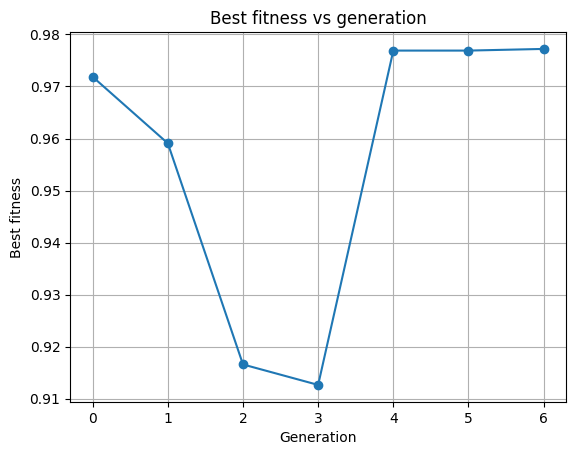

In [35]:
gens = logbDE.select("gen")
best_fitness = logbDE.select("maxDE")
plt.plot(gens, best_fitness, marker = "o")
#plt.xticks(gens[::3])
#plt.yticks(np.linspace(1,8,8))
plt.title("Best fitness vs generation")
#plt.ylim(0.9, 1.0)
plt.xlabel("Generation")
plt.ylabel("Best fitness")
plt.grid()
plt.show()